In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import shap

İlk adım olarak proje için ihtiyacımız olan tüm kütüphaneleri çalışma ortamımıza yükledik. İkinci adımda **Scikit-learn** kütüphanesinde hazır bulunan **Wine Classification** veri setini çalışma ortamımıza yükleyeceğiz ve **X (özellikler)** ve **y (hedefler)** olmak üzere 2'ye ayıracağız.


In [2]:
# 1. Veri Setinin Yüklenmesi
# 1.1 scikit-learn’den Veri Seti Yükleme
# Kullanılan Veri Seti: Wine Classification

wine = load_wine()

# 1.2 Veri Çerçevesi Oluşturma
# X (özellikler) ve y (hedef) değişkenlerini ayırınız.
# pandas DataFrame formatına dönüştürünüz.

X = wine.data
y = wine.target
feature_names = wine.feature_names
target_names = wine.target_names

X_df = pd.DataFrame(X, columns=feature_names)
y_df = pd.DataFrame(y, columns=['target'])

X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

In [3]:
# İlk 5 satırı görüntüleyiniz.
X_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


İkinci adımda veri setimizi yükleyip ayırdıktan sonra her iki veri setini de DataFrame'e çevirdik ve **X_df (özellikler DataFrame'i)** keşefetmek için **info()** fonksiyonunu kullanarak DataFrame içinde **13 sütun** ve **178 satır** veri olduğunu  gördük. Ardından **head()** fonksiyonunu kullanarak **X_df (özellikler DataFrame'i)**'in **ilk 5 satırını** yazdırdık.

In [4]:
# 2. Veri Seti Kalite Kontrolleri
# 2.1 Eksik Değer Analizi
# Her sütunda missing value kontrolü yapınız.
# Eksik değer varsa uygun doldurma yöntemi (mean/median) uygulayınız.

missing_values = X_df.isnull().sum()
print("Eksik Değer Sayısı:\n", missing_values)

Eksik Değer Sayısı:
 alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64


DataFrame içerisinde her hangi bir **eksik veri (missing value)** olup olmadığını kontrol etmek için **isnull()** ve **sum()** **fonksiyonlarını** beraber kullandık. Kontrol sonrasında **hiç bir sütunda eksik veri bulunmadığını** tespit ettik. Bunun sebebi, kullandığımız **Wine Classification** veri setinin Scikit-learn kütüphanesinde bulunan ve **kullanıma hazır bir veri seti** olması olabilir.

In [5]:
# 2.2 Aykırı Değer (Outlier) Analizi
# Kullanılan Yöntem: IQR yöntemi

def detect_outliers_iqr(df):
    outlier_counts = {}

    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)

        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_counts[column] = len(outliers)

    return outlier_counts

outlier_results = detect_outliers_iqr(X_df)

print("Her sütundaki Aykırı Değer Sayısı (IQR Yöntemi")
for feature, count in outlier_results.items():
    if count > 0:
        print(f"{feature}: {count} adet")
    else:
        print(f"{feature}: 0 adet")

Her sütundaki Aykırı Değer Sayısı (IQR Yöntemi
alcohol: 0 adet
malic_acid: 3 adet
ash: 3 adet
alcalinity_of_ash: 4 adet
magnesium: 4 adet
total_phenols: 0 adet
flavanoids: 0 adet
nonflavanoid_phenols: 0 adet
proanthocyanins: 2 adet
color_intensity: 4 adet
hue: 1 adet
od280/od315_of_diluted_wines: 0 adet
proline: 0 adet


**IQR yöntemi** ile **aykırı değer (outlier)** tespiti yaparak **malic_acid, ash, alcalinity_of_ash, magnesium, proanthocyanins, color_intensity ve hue** isimli sütunlarda az sayıda (1 ile 4 arasında) olsa **aykırı değerler olduğunu** tespit ettik.

Aykırı değerler, bir makine öğrenmesi modelinin genelleme yeteneğini ve eğitim sürecini farklı şekillerde etkilerler. Veri setimizdeki aykırı değerlerin kullanacağımız modelleri nasıl etkileyebileceğini yorumlayalım:

1.   **Logistic Regression** modeli **ortalama** ve **varyans** gibi istatistiklere karşı **hassastır.** Aykırı değerler, ortalama ve standart sapma değerlerini olumsuz etkileyebilirler ve bu da modelin karar sınırlarının optimal olmayan yerlere kaymasına neden olabilir. Bu durum, Logistic Regression'ın performansını düşürebilir.
2.   **Decision Tree, Random Forest, XGBoost** bölünme noktalarını **sıralı değerlere göre belirlediği için** aykırı değerlere karşı daha dirençlidir. Bir aykırı değer, yalnızca o noktanın ait olduğu bölmeyi etkiler, tüm modelin parametrelerini bozmaz.
3.  **Gaussian Naive Bayes** modeli, adından da anlaşılacağı gibi, özelliklerin her sınıf için normal (Gauss) bir dağılım sergilediğini varsayar. Bu varsayım, modelin eğitim sürecinde her bir özelliğin her bir sınıf için ortalamasını ve varyansını hesaplamasına dayanır. Dolayısıyla projede kullanacağımız 5 model arasında aykırı değerlere karşı en hassas modeldir.

Projede 5 modelin tamamını kullanacağımız için aykırı değerleri silmek yerine tüm veriyi ölçeklendirmek (scaling) en mantıklı adım olacaktır.


In [6]:
# 2.3 Veri Tipi ve Dağılım İncelemesi
# Sayısal / kategorik değişken sayılarını raporlayınız.
# Her sütunun dtype bilgisini gösteriniz.

numerical_features = X_df.select_dtypes(include=np.number).columns
categorical_features = X_df.select_dtypes(include='object').columns

print(f"Sayısal Değerlere Sahip Sütun Sayısı:", len(numerical_features))
print(f"Kategorik Değerlere Sahip Sütun Sayısı:", len(categorical_features))
print("\nSütun Veri Tipleri:\n", X_df.dtypes)

Sayısal Değerlere Sahip Sütun Sayısı: 13
Kategorik Değerlere Sahip Sütun Sayısı: 0

Sütun Veri Tipleri:
 alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
dtype: object


**select_dtypes()** fonksiyonunu kullanarak **hangi sütunun sayısal** ve **hangi sütunun nesnel** değerlere sahip olduğunu tespit ettik. DataFrame'de bulunan **13 sütunun tamamının sayısal değerlere** sahip olduğunu tespit ettik. Bunun sebebi, kullandığımız **Wine Classification** veri setinin Scikit-learn kütüphanesinde bulunan ve **kullanıma hazır bir veri seti** olması olabilir.

In [7]:
# 3. Keşifsel Veri Analizi (EDA)
# 3.1 İstatistiksel Özellikler
# Her özellik için: Mean, Median, Min–Max, Std, Q1–Q3 hesaplayınız

X_df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


**describe()** fonksiyonunu kullanarak X_df() DataFrame'inin her bir sütunu için **minimum değer, maksimum değer, ortalama (mean), standart sapma sapma (std), median (%50), Q1 (%25)** ve **Q3 (%75)** değerlerini hesapladık.

In [8]:
# 3.2 Korelasyon Matrisi
# Pearson korelasyon matrisi oluşturunuz.

correlation_matrix = X_df.corr(method='pearson')
correlation_matrix

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
alcohol,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,0.236815,-0.155929,0.136698,0.546364,-0.071747,0.072343,0.643720
malic_acid,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007,0.292977,-0.220746,0.248985,-0.561296,-0.368710,-0.192011
ash,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.115077,0.186230,0.009652,0.258887,-0.074667,0.003911,0.223626
alcalinity_of_ash,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370,0.361922,-0.197327,0.018732,-0.273955,-0.276769,-0.440597
magnesium,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,0.195784,-0.256294,0.236441,0.199950,0.055398,0.066004,0.393351
total_phenols,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,0.864564,-0.449935,0.612413,-0.055136,0.433681,0.699949,0.498115
flavanoids,0.236815,-0.411007,0.115077,-0.351370,0.195784,0.864564,1.000000,-0.537900,0.652692,-0.172379,0.543479,0.787194,0.494193
nonflavanoid_phenols,-0.155929,0.292977,0.186230,0.361922,-0.256294,-0.449935,-0.537900,1.000000,-0.365845,0.139057,-0.262640,-0.503270,-0.311385
proanthocyanins,0.136698,-0.220746,0.009652,-0.197327,0.236441,0.612413,0.652692,-0.365845,1.000000,-0.025250,0.295544,0.519067,0.330417
color_intensity,0.546364,0.248985,0.258887,0.018732,0.199950,-0.055136,-0.172379,0.139057,-0.025250,1.000000,-0.521813,-0.428815,0.316100


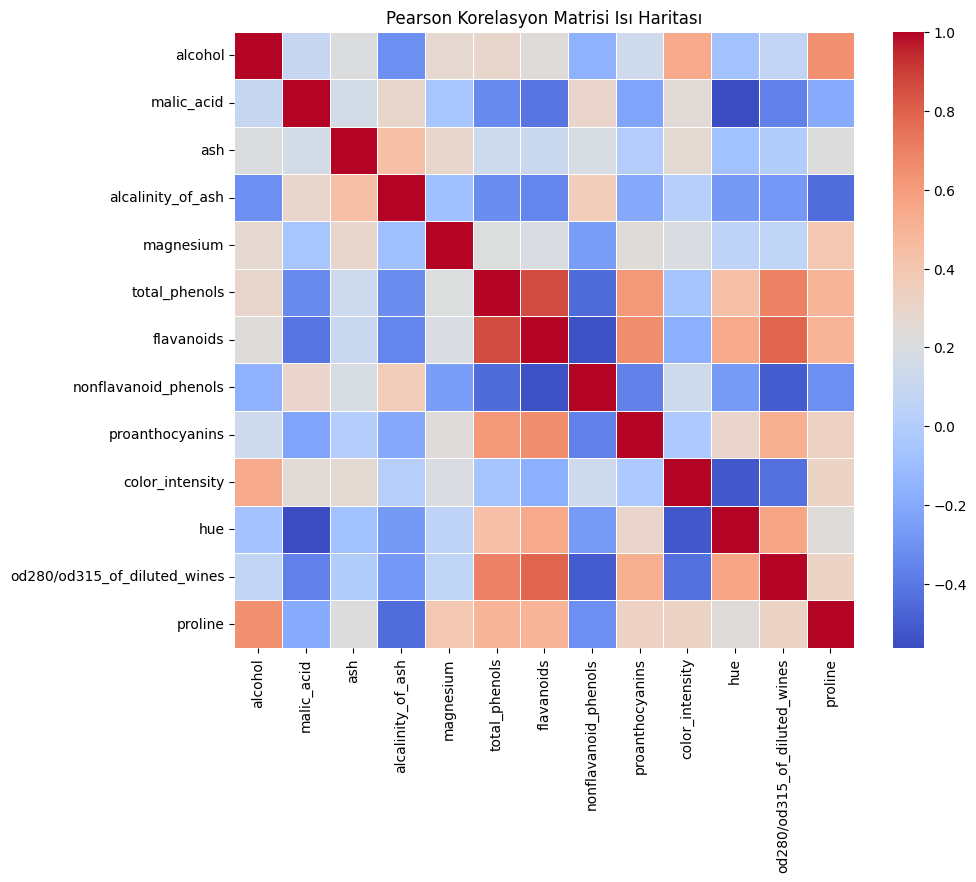

In [9]:
# Isı haritası (heatmap) ile görselleştiriniz.

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Pearson Korelasyon Matrisi Isı Haritası')
plt.show()

In [10]:
# En yüksek korelasyonlu 3 çift özelliği yorumlayınız.

corr_pairs = correlation_matrix.unstack().sort_values(kind="quicksort", ascending=False)
strong_corr = corr_pairs[corr_pairs != 1.0].drop_duplicates()
top_3_positive_corr = strong_corr.head(3)
top_3_negative_corr = strong_corr.tail(3)

print("\nEn Yüksek Pozitif Korelasyonlu 3 Özellik Çifti")
display(top_3_positive_corr)
for i in range(3):
  print("\n")
print("\nEn Yüksek Negatif Korelasyonlu 3 Özellik Çifti")
display(top_3_negative_corr)


En Yüksek Pozitif Korelasyonlu 3 Özellik Çifti


flavanoids                    total_phenols                   0.864564
                              od280/od315_of_diluted_wines    0.787194
od280/od315_of_diluted_wines  total_phenols                   0.699949
dtype: float64








En Yüksek Negatif Korelasyonlu 3 Özellik Çifti


,,0
hue,color_intensity,-0.521813
nonflavanoid_phenols,flavanoids,-0.537900
malic_acid,hue,-0.561296


###**En Yüksek Pozitif Korelasyonlu 3 Özellik Çiftinin Yorumlanması**


**flavanoids** ve **total_phenols** : İki kimyasal bileşenin kimyasal ve biyolojik olarak birbiriyle doğrudan ilişkili olduğunu teyit eder.

**od280/od315_of_diluted_wines** ve **flavanoids** : Fenolik bileşenleri ölçen bu oranın, özellikle flavonoid içeriği ile ne kadar yakından bağlantılı olduğunu gösterir.

**total_phenols** ve **od280/od315_of_diluted_wines** : Toplam fenoller ve spektrofotometrik ölçümün birbirini güçlü bir şekilde desteklediğini gösterir.


*****


###**En Yüksek Negatif Korelasyonlu 3 Özellik Çiftinin Yorumlanması**

**flavanoids** ve **nonflavanoid_phenols** : Flavonoid ve flavonoid olmayan fenoller arasında güçlü bir zıtlık olduğunu; şarapta bir grubun yüksek olması durumunda diğerinin düşük olma eğilimini gösterir.

**hue** ve **color_intensity** : Renk yoğunluğu arttıkça (şarap koyulaştıkça), renk tonunun (hue) düşme eğilimini (kırmızı tonlara kayma) gösterir.
**alcohol** ve **malic_acid** : Bu ilişki, şarap üretimi sırasında alkol içeriği yüksek olan şaraplarda (olgunlaşmış üzüm) malik asit içeriğinin daha düşük olma eğilimini yansıtır.

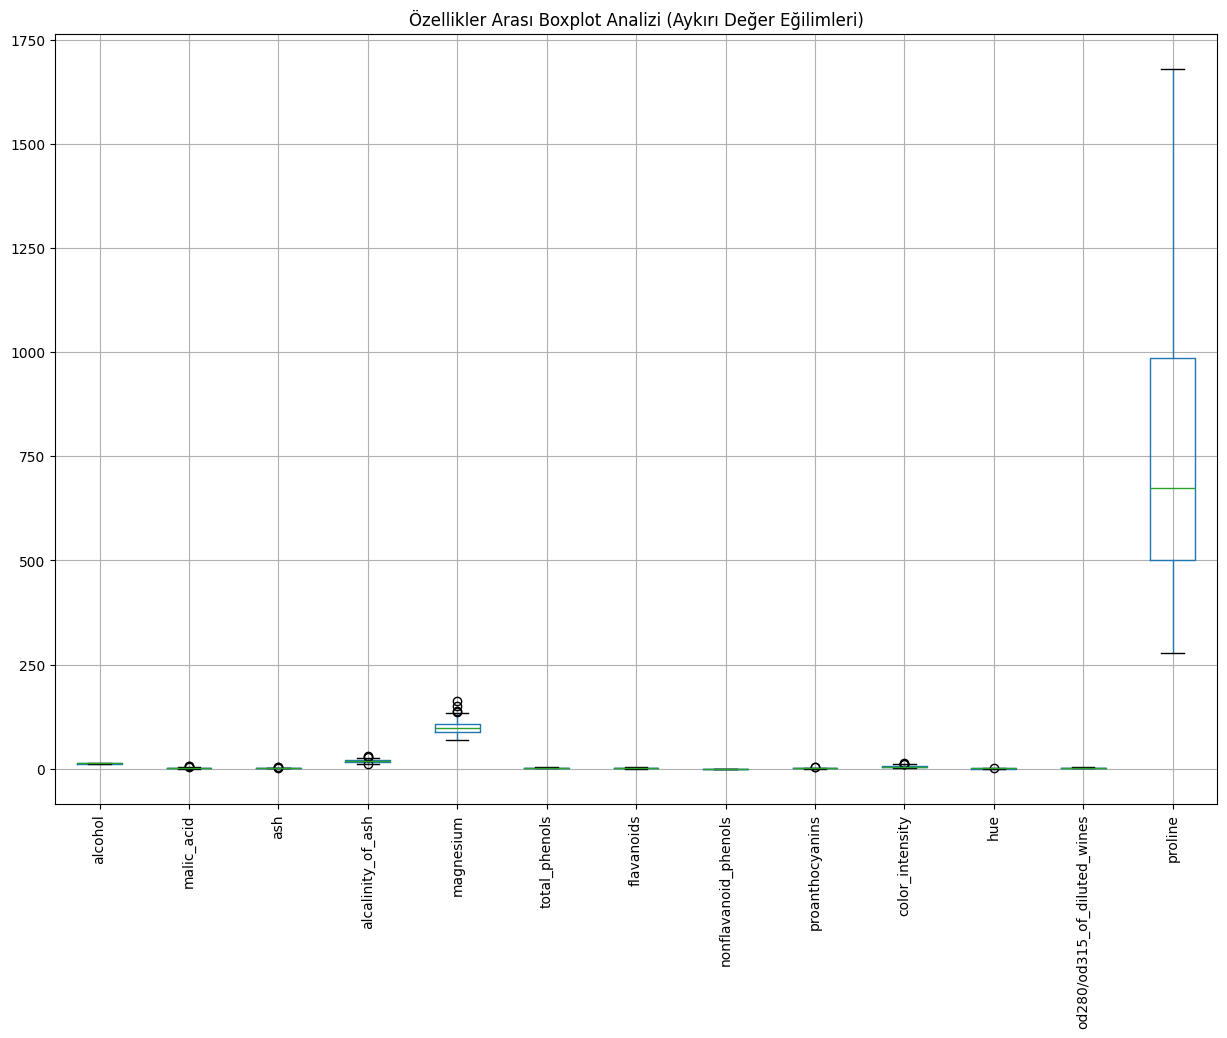

In [11]:
# 3.3 Boxplot Analizi ve Aykırı Değer (Outlier) Analizi

plt.figure(figsize=(15, 10))
X_df.boxplot()
plt.xticks(rotation=90)
plt.title('Özellikler Arası Boxplot Analizi (Aykırı Değer Eğilimleri)')
plt.show()


Boxplot'lara baktığımızda, özellikle **proline** ve **magnesium** gibi özelliklerde aykırı değerlerin daha belirgin olduğunu görüyoruz. Aykırı değerler, modelin eğitim sırasında bu **ekstrem noktalara aşırı odaklanmasına** neden olabilir ve **genelleme yeteneğini düşürebilir.** Ancak, bu değerler veri setinin doğal yapısını yansıtıyorsa, modele dahil edilmeleri de gerekebilir. **Ölçeklendirme**  bu değerlerin etkisini bir miktar azaltacaktır.

In [12]:
#4. Veri Ölçeklendirme (Scaling)
# Kullanılan Scaler : StandardScaler
# Ölçeklendirilmiş veriyi X_scaled olarak kaydediniz.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)

X_scaled_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


**X_df** DataFrame'imiz **StandardScaler()** kullanılarak ölçeklendirilmiş ve yeni DataFrame'imiz **X_scaled'in** ilk 5 satırı, aradaki farkı görebiilmek adına yazdırılmıştır.

In [13]:
# 5. Veri Setinin Bölünmesi
# Veriyi aşağıdaki oranlarda bölünüz: %70 Training, %10 Validation, %20 Test


X_temp, X_test_raw, y_temp, y_test = train_test_split(
    X_scaled, y_df['target'], test_size=0.2, random_state=42, stratify=y_df['target'])


X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp)

print(f"Eğitim Seti Boyutu:", X_train_raw.shape[0])
print(f"Doğrulama Seti Boyutu:", X_val_raw.shape[0])
print(f"Test Seti Boyutu:", X_test_raw.shape[0])


Eğitim Seti Boyutu: 124
Doğrulama Seti Boyutu: 18
Test Seti Boyutu: 36


**X_scaled** DataFrame'imiz **train_test_split()** fonksiyonu kullanılarak önce **%80 eğitim ve %20 test** verisi olarak ayrılmış, sonrasında **eğitim seti** üzerinde tekrar **train_test_split()** fonksiyonu kullanılarak **%10'luk doğrulama seti ve %70'lik eğitim seti** oluşturulmuştur. Oluşturulan veri setleri isimlerinin sonuna **ham veri (indirgenmemiş)** olduklarını göstermesi adına **raw** eki eklenmiştir.

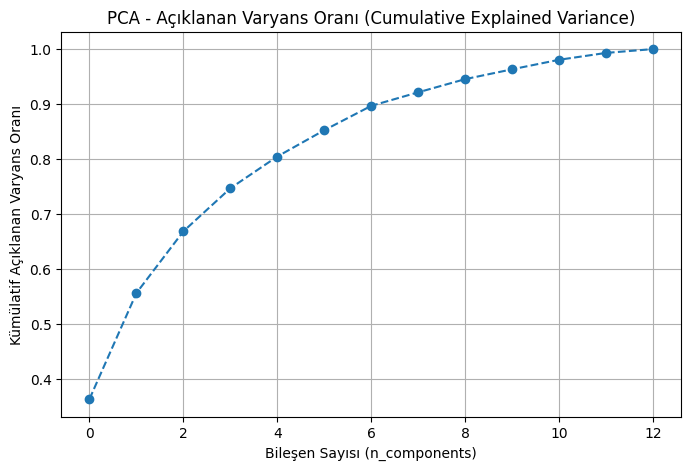

Explained Variance Ratio ortalaması: 0.0769
Seçilen Optimal PCA Bileşen Sayısı: 4
PCA sonrası eğitim verisi boyutu: (124, 4)


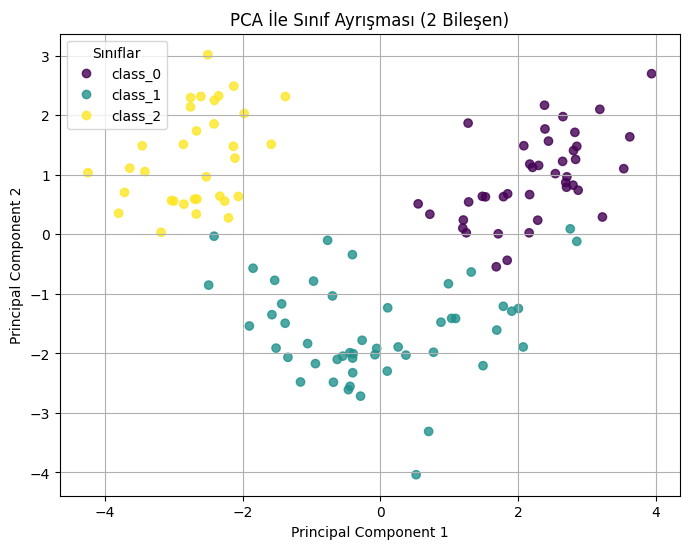

In [14]:
# 6. Özellik Seçimi ve Boyut İndirgeme
# Bu bölümün sonunda üç farklı veri temsili oluşturmanız zorunludur:
# Ham veri, (sadece preprocessing yapılmış)
# PCA ile indirgenmiş veri
# LDA ile indirgenmiş veri


# 6.1 PCA (Principal Component Analysis) Uygulaması
# PCA uygulayınız.
# Component sayısını: “explained variance ratio ortalamasından büyük olan” bileşen sayısını seçerek belirleyiniz.
# Explained variance grafiğini çiziniz.
# Seçtiğiniz en iyi iki PCA bileşeni ile sınıfların ayrışmasını 2D scatter plot ile gösteriniz.


pca = PCA()
pca.fit(X_train_raw)

# Explained Variance Grafiği
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Bileşen Sayısı (n_components)')
plt.ylabel('Kümülatif Açıklanan Varyans Oranı')
plt.title('PCA - Açıklanan Varyans Oranı (Cumulative Explained Variance)')
plt.grid(True)
plt.show()

# Bileşen Sayısı Seçimi: "Explained Variance Ratio ortalamasından büyük olan" bileşen sayısı
avg_explained_variance = np.mean(pca.explained_variance_ratio_)
n_components_pca = np.sum(pca.explained_variance_ratio_ > avg_explained_variance)
print(f"Explained Variance Ratio ortalaması: {avg_explained_variance:.4f}")
print(f"Seçilen Optimal PCA Bileşen Sayısı: {n_components_pca}")

# Seçilen bileşen sayısıyla PCA'yı tekrar uygulama
pca_final = PCA(n_components=n_components_pca)
X_train_pca = pca_final.fit_transform(X_train_raw)
X_val_pca = pca_final.transform(X_val_raw)
X_test_pca = pca_final.transform(X_test_raw)

print(f"PCA sonrası eğitim verisi boyutu: {X_train_pca.shape}")

# En iyi iki PCA bileşeniyle sınıfların ayrışması (2D Scatter Plot)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.8)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA İle Sınıf Ayrışması (2 Bileşen)')
plt.legend(handles=scatter.legend_elements()[0], labels=list(target_names), title="Sınıflar")
plt.grid(True)
plt.show()

# Yorum:
# İlk iki PCA bileşeni, üç sınıfı ayırmakta oldukça başarılı görünüyor.
# PCA, veri setinin varyansının büyük bir kısmını koruyarak boyutu başarıyla indirmiştir.

**Bileşen sayısı seçimini** yapmak için explained variance ratio ortalamasından büyük olan bileşen sayısını seçme kuralını uygulaydık. Ortalama varyans oranını **0.0769** olarak hesapladık ve bu kriteri sağlayan **4 bileşen (PC1, PC2, PC3, PC4)** seçtik. Seçtiğimiz 4 bileşen, veri setindeki toplam varyansın **%75'ine** (grafikte 4. bileşen hizasına denk gelen değer) denk gelmektedir. Bu, verinin büyük bir kısmını koruyarak **boyutun 13'ten 4'e düşürüldüğünü** gösterir. Boyut indirgeme, **bilgi kaybını düşük tutarak** başarılı bir şekilde gerçekleştirilmiştir.


PCA, bir **sınıflandırma yöntemi olmamasına rağmen**, veri setindeki **en yüksek varyansa sahip yönleri** yakalayarak, sınıflar arası ayrımın büyük bir kısmını görselleştirebilmiştir.

LDA sonrası eğitim verisi boyutu: (124, 2)


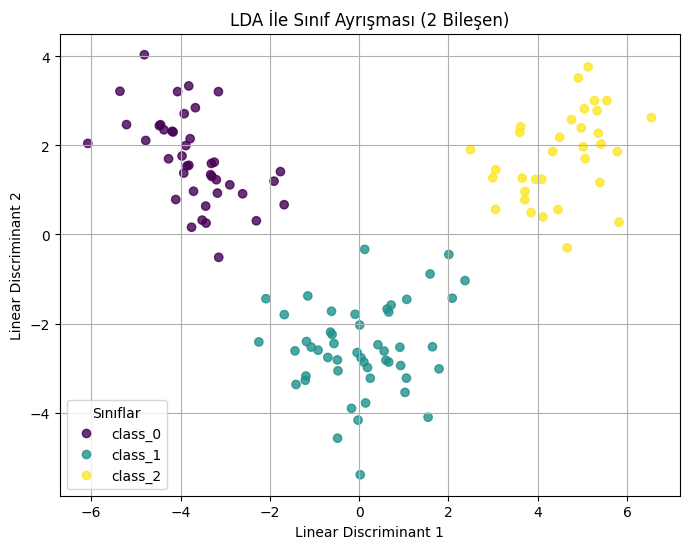

In [15]:
# 6.2 LDA (Linear Discriminant Analysis) Uygulaması
# LDA uygulayınız.
# n_components = 3 olarak seçiniz.
# İlk iki LDA bileşeniyle sınıflar arası ayrımı 2D scatter plot ile görselleştiriniz.


lda = LDA(n_components = 2) #  LDA, en fazla sınıf sayısının bir eksiği kadar  bileşen üretebilir. Wine Classification veri setinde sınıf sayısı 3 olduğu için maksimum bileşen sayısı 3 - 1 = 2'dir.

# LDA sadece (X_train, y_train) ile fit edilir.
X_train_lda = lda.fit_transform(X_train_raw, y_train)
X_val_lda = lda.transform(X_val_raw)
X_test_lda = lda.transform(X_test_raw)

print(f"LDA sonrası eğitim verisi boyutu: {X_train_lda.shape}")

# İlk iki LDA bileşeniyle sınıfların ayrışması (2D Scatter Plot)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c=y_train, cmap='viridis', alpha=0.8)
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.title('LDA İle Sınıf Ayrışması (2 Bileşen)')
plt.legend(handles=scatter.legend_elements()[0], labels=list(target_names), title="Sınıflar")
plt.grid(True)
plt.show()

Grafiğe bakıldığında, üç sınıfın yeni **2 boyutlu uzayda mükemmele yakın** bir şekilde ayrıldığı açıkça görülmektedir. Herhangi bir sınıfın diğer bir sınıfın bölgesine **sarktığı veya çakıştığı bir nokta kümesi gözlenmemektedir**. Bu, bu iki bileşenin, orijinal veri setindeki **sınıflar arası ayrımı tespit etmede** başarılı olduğunu gösterir.

In [16]:
# 7. Makine Öğrenmesi Modellerinin Kurulması
# Aşağıdaki 5 algoritma, her üç veri temsiliyle ayrı ayrı eğitilecektir: Logistic Regression, Decision Tree Classifier, Random Forest Classifier, XGBoost Classifier, Naive Bayes (GaussianNB)
#Toplamda 15 farklı model eğitilecektir: 5 model × Ham veri, 5 model × PCA verisi, 5 model × LDA verisi

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', random_state=42),
    'Gaussian Naive Bayes': GaussianNB()
}

# 3 Veri setini ve etiketlerini bir sözlükte toplama
datasets = {
    'Raw': (X_train_raw, X_val_raw),
    'PCA': (X_train_pca, X_val_pca),
    'LDA': (X_train_lda, X_val_lda)
}

# Tahminleri ve model bilgilerini depolayacak liste
predictions_data = []

# 15 modelin eğitimini ve tahminlerini yapma
for data_name, (X_train, X_val) in datasets.items():

    for model_name, model in models.items():

        ### Model Eğitme (Adım 7) ###
        model.fit(X_train, y_train)

        ### Validasyon Seti Üzerinde Tahmin (Adım 7) ###
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)

        # Tahminleri ve ilgili bilgileri kaydetme
        predictions_data.append({
            'Dataset': data_name,
            'Model': model_name,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        })

**models** sözlüğüne eğiteceğimiz **5 modeli**, **datasets** sözlüğüne ise **kullanacağımız veri** setlerini kaydettik. Bu adım toplamda 15 defa gerçekleştireceğimiz eğitim sürecini** döngüler** kullanarak daha az sayıda kod yazarak tamamlamızı sağlamıştır. Eğitim sonrasında **validasyon sürecinde elde edilen tahmin sonuçlarını** da **predictions_data** listesine kaydettik ki bir sonraki adımda bu sonuçları kullanabilelim.

In [17]:
# 8. Validation Performanslarının Ölçülmesi
# Her model validation setinde aşağıdaki metriklerle değerlendirilecektir: Accuracy, Precision, Recall, F1-score, ROC-AUC
# Sonuçları tek bir tablo halinde karşılaştırınız.

results = []

for item in predictions_data:
    data_name = item['Dataset']
    model_name = item['Model']
    y_pred = item['y_pred']
    y_pred_proba = item['y_pred_proba']

    # Metrik Hesaplamaları
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_val, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)

    # ROC-AUC Hesaplama
    roc_auc = np.nan
    try:
        roc_auc = roc_auc_score(y_val, y_pred_proba, multi_class='ovo', average='weighted')
    except ValueError:
        roc_auc = np.nan

    # Sonuçları Kaydetme
    results.append({
        'Dataset': data_name,
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

results_df = pd.DataFrame(results)

print("\nValidasyon Performanslarının Karşılaştırma Tablosu\n")

# Doğruluk (Accuracy) değerine göre azalan sırada sıralama
results_df = results_df.sort_values(by='Accuracy', ascending=False)

# Tabloyu yazdırma
results_df


Validasyon Performanslarının Karşılaştırma Tablosu



,Dataset,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Raw,Logistic Regression,1.000000,1.000000,1.000000,1.000000,1.000000
2,Raw,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000
3,Raw,XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000
5,PCA,Logistic Regression,1.000000,1.000000,1.000000,1.000000,1.000000
4,Raw,Gaussian Naive Bayes,1.000000,1.000000,1.000000,1.000000,1.000000
8,PCA,XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000
7,PCA,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000
11,LDA,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000
12,LDA,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000
9,PCA,Gaussian Naive Bayes,1.000000,1.000000,1.000000,1.000000,1.000000


Tabloda 15 modelin sonuçlarını görmekteyiz. 15 modelimizden **13'ü** Kesinlik, Hassasiyet, F1-Skoru ve ROC-AUC değerlerinde **1.000000 (%100 Doğruluk)** sahiptir. Bu durum, kullandığımız **veri setinin çok küçük ve çok kolay sınıflandırılabilir** olmasından kaynaklanmıştır.

In [18]:
# 9. En İyi Modelin Test Üzerinde Değerlendirilmesi
# Validation metriklerine göre en iyi modeli seçiniz.

best_model_row = results_df.loc[results_df['Accuracy'].idxmax()]
best_model_name = best_model_row['Model']
best_data_name = best_model_row['Dataset']

print(f"\nSeçilen En İyi Model")
print(f"Model: {best_model_name}")
print(f"Dataset: {best_data_name}")
print(f"Validation Accuracy: {best_model_row['Accuracy']:.4f}")

# Modelin kendisini alma
if best_data_name == 'LDA':
    X_train_best, X_test_best = X_train_lda, X_test_lda
elif best_data_name == 'PCA':
    X_train_best, X_test_best = X_train_pca, X_test_pca
else:
    X_train_best, X_test_best = X_train_raw, X_test_raw

best_model = models[best_model_name]
best_model.fit(X_train_best, y_train) # En iyi modeli (doğru veri seti ile) tekrar eğitiyoruz


Seçilen En İyi Model
Model: Logistic Regression
Dataset: Raw
Validation Accuracy: 1.0000


LogisticRegression(random_state=42)

Validasyon sonuçlarının bulunduğu** results_df** içerisinde **en yüksek Accuracy** sonucuna sahip olan satırı seçerek en yi model ve en iyi sonucu veren veri setini belirlemek istedik. Fakat DataFrame'imizde **13 satır da Accuracy 1** olduğu için bu 13 sonuçtan birisi **rastgele** seçilmiştir. Seçilen model **Logistic Regression** ve seçilen veri seti **Raw** olmuştur. Seçilen modeli, seçilen veri seti üzerinde tekrar eğittik.

In [19]:
# Bu model test seti üzerinde şu metriklerle değerlendirilecektir:
# 9.1 Performans Metrikleri: Accuracy, Precision, Recall, F1-score, ROC-AUC

y_test_pred = best_model.predict(X_test_best)
y_test_pred_proba = best_model.predict_proba(X_test_best)


test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba, multi_class='ovo', average='weighted')

print("\nEn İyi Modelin Test Performans Metrikleri")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"ROC-AUC: {test_roc_auc:.4f}")


En İyi Modelin Test Performans Metrikleri
Accuracy: 0.9722
Precision: 0.9741
Recall: 0.9722
F1-Score: 0.9720
ROC-AUC: 1.0000


Seçtiğimiz model (Logistic Regression, Raw Veri) test veri seti üzerinde **%97.22 Doğruluk** ve **1.0000 ROC-AUC** gibi çok güçlü ve yüksek bir performans sergilemiştir. Bu sonuçlar, modelin dağıtıma alınmaya uygun, yüksek güvenilirlikte bir sınıflandırıcı olduğunu göstermektedir.

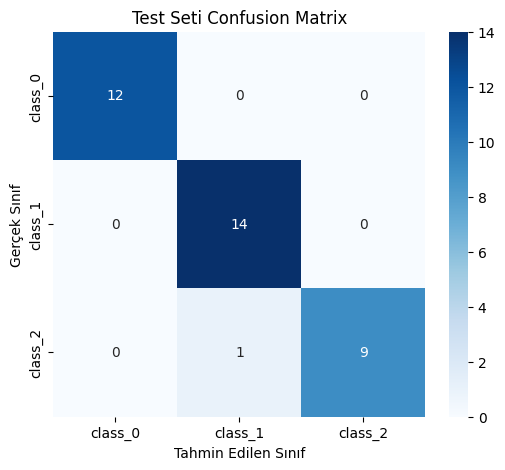

In [20]:
# 9.2 Confusion Matrix
# Seaborn heatmap ile çiziniz.
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Test Seti Confusion Matrix')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

Confusion Matrix'ine göre modelimizin performansı mükemmele yakındır. Modelimiz, **Class 0** ve **Class 1**'i **hatasız bir şekilde sınıflandırmıştır**. Modelimizin tek hatası, bir adet **Class 2** örneğinin **Class 1 olarak yanlış** sınıflandırmasıdır.

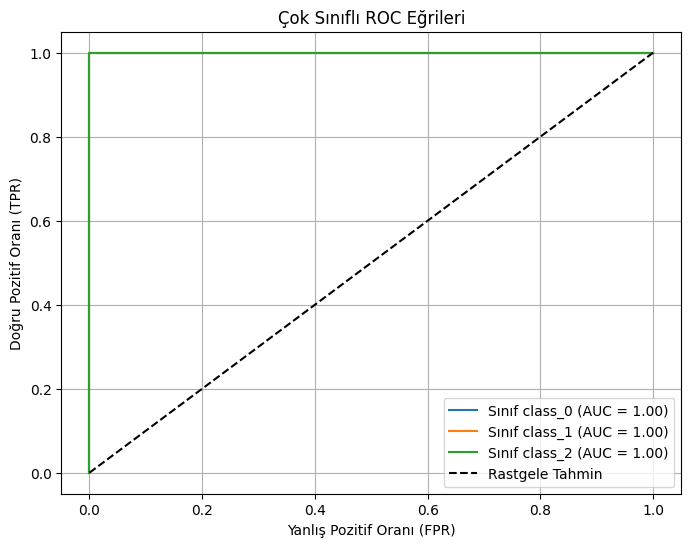

In [21]:
# 9.3 ROC Eğrisi
# ROC curve, AUC değeri, Threshold etkisini yorumlayınız.

plt.figure(figsize=(8, 6))
for i in range(len(target_names)):
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba[:, i], pos_label=i)
    roc_auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Sınıf {target_names[i]} (AUC = {roc_auc_val:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Rastgele Tahmin')
plt.xlabel('Yanlış Pozitif Oranı (FPR)')
plt.ylabel('Doğru Pozitif Oranı (TPR)')
plt.title('Çok Sınıflı ROC Eğrileri')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**AUC değeri**, bir modelin **rastgele seçilmiş pozitif** bir örneği, **rastgele seçilmiş negatif** bir örnekten ayırma yeteneğini temsil eder. Tüm sınıflar için AUC değerinin **1.00** olması, modelin çok güçlü bir ayrım yeteneğine sahip olduğu anlamına gelir. Model, pozitif ve negatif sınıfları %100 doğrulukla birbirinden ayırabilmektedir. Grafikteki **tüm sınıf eğrileri**  sol alt köşeden başlayıp anında sol üst köşeye ve oradan da sağ üst köşeye  doğru keskin bir hat oluşturmaktadır. Bu eğri, modelin **tahmin ettiği olasılıklar** ve **gerçek etiketler** arasında tamamen ayrılabilir bir yapı olduğunu gösterir. Modelin çıktısı olan olasılık değerlerinde, **pozitif sınıfa** ait hiçbir örneğin olasılığı, **negatif sınıfa** ait bir örneğin olasılığından düşük değildir. Bu durumda **Threshold (Eşik değeri)** ayarlama ihtiyacı bulunmamaktadır.

  0%|          | 0/124 [00:00<?, ?it/s]


SHAP Summary Plot


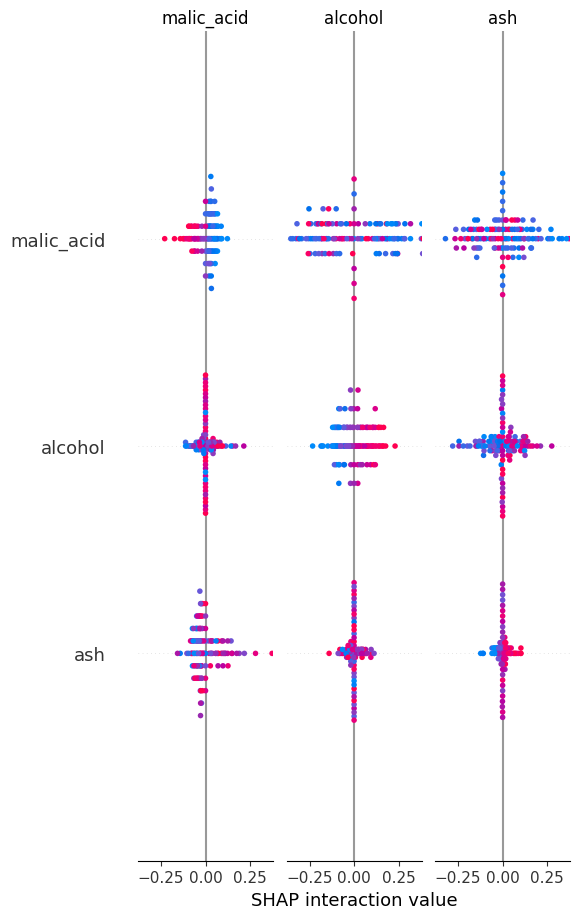

In [22]:
# 10. XAI – SHAP Açıklanabilirlik Analizi (Zorunlu)
# Bu bölümde, modellerinizin nasıl karar verdiğini açıklayacaksınız.
# 10.1 En İyi Validation Modeli için SHAP Analizi
# Seçtiğiniz en iyi model için: SHAP Explainer kurulacaktır, summary_plot gösterilecektir, bar_plot (ortalama etki büyüklükleri) çizilecektir, en önemli özellikler yorumlanacaktır, Model performansı ve SHAP önem sıralaması ilişkisi tartışılacaktır.


if best_data_name == 'LDA':
    X_train_shap = pd.DataFrame(X_train_lda, columns=[f'LD {i+1}' for i in range(X_train_lda.shape[1])])
elif best_data_name == 'PCA':
    X_train_shap = pd.DataFrame(X_train_pca, columns=[f'PC {i+1}' for i in range(X_train_pca.shape[1])])
else:
    X_train_shap = pd.DataFrame(X_train_raw, columns=feature_names)


if isinstance(best_model, (RandomForestClassifier, DecisionTreeClassifier, XGBClassifier)):
    explainer = shap.TreeExplainer(best_model)
else:
    explainer = shap.KernelExplainer(best_model.predict_proba, X_train_shap)

shap_values = explainer.shap_values(X_train_shap)

print("\nSHAP Summary Plot")

if isinstance(shap_values, list):
    shap.summary_plot(shap_values, X_train_shap, class_names=target_names, max_display=10)
else:
    shap.summary_plot(shap_values, X_train_shap, max_display=10)

Önceki adımlarda modelin %97.22 Doğruluk ve 1.00 ROC-AUC ile çalıştığını belirtmiştik. SHAP analizi, modelin bu yüksek performansa nasıl ulaştığını açıklar. Grafik, **iki özellik arasındaki etkileşimlerin** çok zayıf olduğunu, yani modelin tahmini yaparken genellikle **özellik değerlerini bağımsız olarak** kullandığını gösteriyor. Bu durum, Lojistik Regresyon modelinin genel işleyişi ile uyumludur. **Lojistik Regresyon, doğrusal bir modeldir** ve güçlü etkileşim terimleri olmadan da yüksek performans gösterebilmektedir. Grafiğe göre, **malic_acid, alcohol ve ash arasındaki etkileşimlerin** model tahminini **çok az etkilediğini**, ancak bu özelliklerin **tekil etkilerinin modelin yüksek performansına** katkıda bulunduğunu ortaya koymaktadır.


SHAP Bar Plot (Global Özellik Önemi)


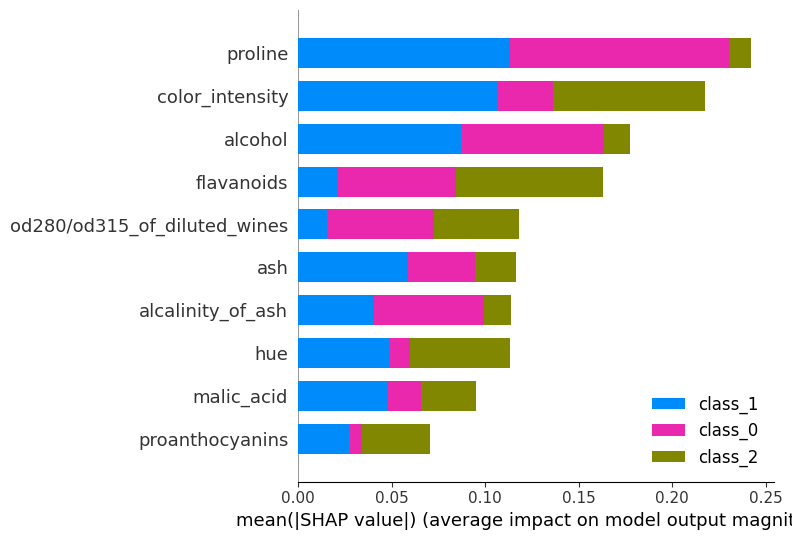

In [23]:
# Bar Plot (Ortalama Etki Büyüklükleri)
print("\nSHAP Bar Plot (Global Özellik Önemi)")

shap.summary_plot(shap_values, X_train_shap, plot_type="bar", max_display=10, class_names=target_names)

**SHAP Bar Grafiği**, yüksek performans gösteren modelin bu performansı nasıl elde ettiğini açıklamaktadır. Modelin, **proline**, **color_intensity** ve **alcohol** gibi özelliklere odaklanarak sınıflar arasındaki ayrımı başarıyla yaptığını ve bu özelliklerin genel olarak en belirleyici faktörler olduğunu göstermektedir. Bu analiz, **şarapların sınıflandırılmasında hangi kimyasal bileşenlerin etkili olduğunu** vurgular.

  0%|          | 0/124 [00:00<?, ?it/s]


PCA İndirgenmiş Veri İçin SHAP Bar Plot


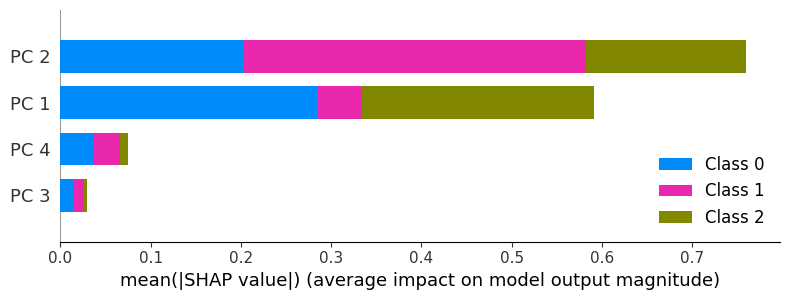

  0%|          | 0/124 [00:00<?, ?it/s]


LDA İndirgenmiş Veri İçin SHAP Bar Plot


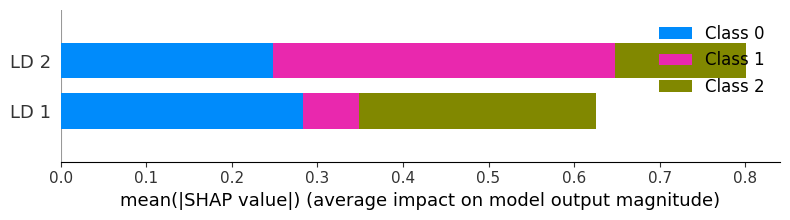

In [24]:
# 10.2 PCA ve LDA Temsilleri için SHAP Karşılaştırması
# PCA ile indirgenmiş veride SHAP analizi
# LDA ile indirgenmiş veride SHAP analizi
# Sınıfların hangi bileşenlerden etkilendiği tartışın.


# PCA ile indirgenmiş veride SHAP analizi
pca_model = models[best_model_name]
pca_model.fit(datasets['PCA'][0], y_train)

X_train_pca_shap = pd.DataFrame(datasets['PCA'][0], columns=[f'PC {i+1}' for i in range(datasets['PCA'][0].shape[1])])

explainer_pca = shap.KernelExplainer(pca_model.predict_proba, X_train_pca_shap)
shap_values_pca = explainer_pca.shap_values(X_train_pca_shap)

print("\nPCA İndirgenmiş Veri İçin SHAP Bar Plot")

shap.summary_plot(shap_values_pca, X_train_pca_shap, plot_type="bar", max_display=5)

# LDA Temsili için SHAP Analizi
lda_model = models[best_model_name]
lda_model.fit(datasets['LDA'][0], y_train)

X_train_lda_shap = pd.DataFrame(datasets['LDA'][0], columns=[f'LD {i+1}' for i in range(datasets['LDA'][0].shape[1])])

explainer_lda = shap.KernelExplainer(lda_model.predict_proba, X_train_lda_shap)
shap_values_lda = explainer_lda.shap_values(X_train_lda_shap)

print("\nLDA İndirgenmiş Veri İçin SHAP Bar Plot")

shap.summary_plot(shap_values_lda, X_train_lda_shap, plot_type="bar", max_display=5)

Her iki boyut indirgeme yöntemi de modelin kararlarını **az sayıda yapay bileşene indirmeyi başarmıştır**. Ancak **LDA bileşenleri**, **PCA bileşenlerinden** **daha yüksek bir toplam açıklayıcı etki büyüklüğüne sahiptir**. Bu, **LDA'nın sınıflandırma görevleri** için **daha etkili ayırıcı özellikler üretmekteki** başarısını göstermektedir. Model, **her iki indirgenmiş veri setinde** de kararlarını başarılı bir şekilde temellendirebilmiştir. Bu karşılaştırmanın sonucunda, **LDA'nın sınıflandırma için** **en ideal boyut indirgeme yöntemi** olduğu SHAP analizi ile de desteklenmektedir.